# Download all the files for today's tutorial

# https://tinyurl.com/ANLPColab4Part2

In this notebook, we train a sentiment classifier based on different models (Simple NN, CNN, LSTM, BERT) using movie reviews as the training data. The goal is not to achieve state-of-the-art results but to systematically go through the main stops to solve the classification task by demonstarting the use of different models.

## Steps in the notebook


1.   Load the **IMDb Movie Reviews dataset (50,000 reviews)**
2.   **Pre-process the dataset** by removing special characters, numbers, etc. from user reviews + convert **sentiment labels** positive & negative to numbers 1 & 0, respectively
3.   **Import GloVe Word Embedding** to build Embedding Dictionary + Use this to build Embedding Matrix for our Corpus
4. Model Training using **Deep Learning in Keras** for separate: **Simple Neural Net, CNN and LSTM Models** and analyse model performance and results
5. Lastly, perform **predictions on real IMDb movie reviews**

## Setting the environment

Mount the Google Drive to access your files.

In [29]:
# Mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Download the IMDB Reviews data set and load it into your folder on Google drive. Change folder settings below to point to the right location your file is in


In [14]:
# You can set the current directory as working directory to easily refer to all files from the folder without the full path every time E.g. movie_reviews = pd.read_csv("IMDB_Dataset.csv")

%cd /content/drive/My Drive/Colab Notebooks/ANLP 2024 Colab Notebooks/Session 4 Colab Notebooks/
! ls




[Errno 2] No such file or directory: '/content/drive/My Drive/Colab Notebooks/ANLP 2024 Colab Notebooks/Session 4 Colab Notebooks/'
/content
drive  sample_data


In [15]:
#Install and update packages you don't have - these are for deep learning

!pip install --upgrade keras # Install or upgrade Keras to make sure you have the latest version
!pip install --upgrade tensorflow # Sometimes, installing Keras alone might not include all the necessary sub-packages. You can install TensorFlow, which includes Keras and its dependencies.
## TensorFlow is an open-source machine learning framework developed by Google, commonly used for building and training neural networks: https://www.tensorflow.org/


In [16]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

## Loading the IMDB Movie reviews dataset

In [17]:
# Importing IMDb Movie Reviews dataset

movie_reviews = pd.read_csv("/content/drive/MyDrive/ANLP Week 4 Tutorial_All files/IMDB Dataset.csv")

In [18]:
# Dataset exploration

movie_reviews.shape

(50000, 2)

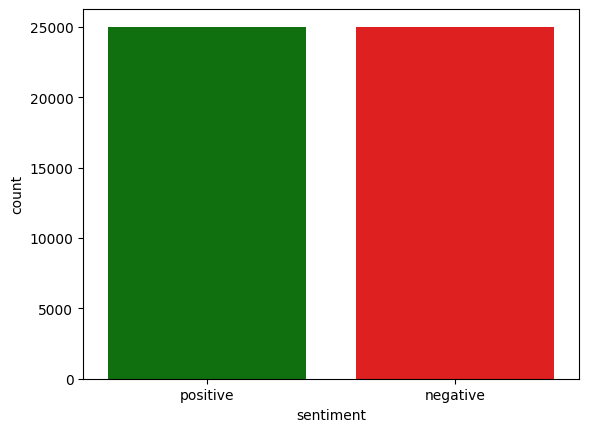

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [19]:
sns.countplot(x="sentiment", data=movie_reviews, palette=["green", "red"], hue="sentiment", dodge=False)
plt.show()
print(movie_reviews.sentiment.value_counts())

In [20]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [21]:
# Checking for missing values

movie_reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

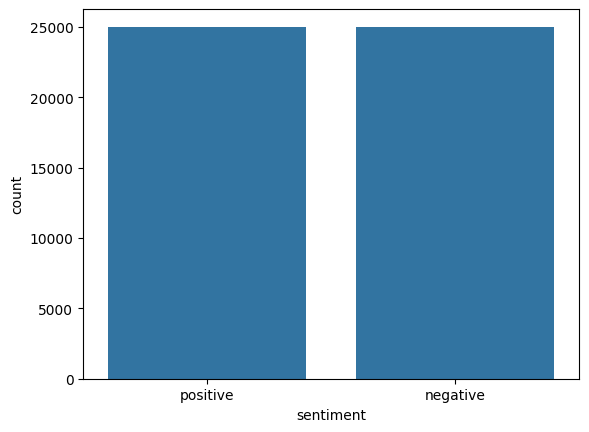

In [22]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

## Data Preprocessing

In [23]:
movie_reviews["review"][2]

# You can see that our text contains punctuations, brackets, HTML tags and numbers
# We will preprocess this text in the next section

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [24]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [25]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Define function for pre-processing the text. Note that we will use Word Embeddings here, so stemming/lemmatization is not performed as a preprocessing step

In [26]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [27]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [28]:
# Let's view a sample cleaned up movie review

X[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Converting sentiment labels to 0 & 1

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models
# while test set will be used to evaluate how well our model performs
# We'll use a 80-20 split

## Preparing the embedding

Let's now create our embedding layer, which will be **the input layer for the deep learning models in Keras**. We'll use Stanford's GloVe 100d word embeddings for this exercise

In [ ]:
# Embedding layer expects the words to be in numeric form
# Using the Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

In [ ]:
# Padding all reviews to fixed length 100

max_tokens = 100

X_train = pad_sequences(X_train, padding='post', maxlen=max_tokens)
X_test = pad_sequences(X_test, padding='post', maxlen=max_tokens)

In [ ]:
X_train.shape

Instead of defining a number for padding, you can also use the maximum number of tokens for padding to be calculated based on the tokens in the data. Here the max tokens is 100

In [ ]:
X_combined = np.concatenate((X_train, X_test), axis=0)

# Take the word count of each of our sentences in our data and create a list
num_tokens = [len(tokens) for tokens in X_combined]
num_tokens = np.array(num_tokens)
num_tokens.shape

In [ ]:
#when setting the number of tokens, a number is determined by taking into account the variability around the average.
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
print("Max tokens: ", max_tokens)

max_tokens # This value will allow us to reduce the distribution of sentences in our data and the sentences with opposite lengths, if any, to the average
maxlen = max_tokens

Optional, but let's create a function to view how a tokenized sentence looks like


In [ ]:
idx = word_tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

def return_to_sentence(tokens):
    words = [inverse_map[token] for token in tokens if token!=0]
    text = ' '.join(words)
    return text

In [ ]:
print("This is a sample text comment:")
print(return_to_sentence(X_train[9]))

print("\nThis is the padded, tokenized comment:")
print(X_train[9])

We'll use the pre-trained **GloVe (Global Vectors for Word Representation) 'glove.6B.100d.txt' embedding**, which you can download from ... and store in your folder. Glove offers vectors in standard dimensions such as 50, 100, 200, and 300. For many tasks, 100 dimensions have been found to offer a good trade-off between performance and computational efficiency.

The below code reads the embedding file line by line. For each line, it splits the line into a word and its corresponding vector dimensions. It then stores these in a dictionary called embeddings_dictionary, where each word is a key and its vector is the value.

In [ ]:
# Load GloVe and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split() #Each line in the GloVe file typically contains a word followed by its vector representation. The split() method splits the line into a list of strings (records) based on whitespace.
    word = records[0] #The first element of the records list is the word itself.
    vector_dimensions = asarray(records[1:], dtype='float32') #The remaining elements of the records list (from index 1 onwards) are the vector dimensions. These are converted into a NumPy array of type float32 using asarray
    embeddings_dictionary [word] = vector_dimensions #The embeddings_dictionary is a dictionary where the key is the word and the value is its corresponding vector. This line adds an entry to the dictionary.
glove_file.close()

In the following code snippet, we create an embedding matrix where each row corresponds to a word in our vocabulary, and each row contains the pre-trained embedding vector for that word. If a word from our vocabulary is not found in the pre-trained embeddings dictionary, its row in the embedding matrix remains as zeros.

In [ ]:
# Create the Embedding Matrix with 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus

embedding_matrix = zeros((vocab_length, 100)) #Initialize an embedding matrix with zeros
for word, index in word_tokenizer.word_index.items(): #This loop iterates over each word and its corresponding index in the word_tokenizer.word_index dictionary.
    embedding_vector = embeddings_dictionary.get(word) # Retrieve the word's corresponding embedding vector from the embeddings_dictionary, returns none if not found
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

The shape of the embedding_matrix will be (vocab_length, 100). We have 92394 unique words in our vocabulary. 100 is the dimension of the word vectors.

In [ ]:
print ("Sample embedding:\n")
embedding_matrix[1,]

# Model Training with different models:

## Simple (feed-forward) Neural Network

Let's build a simple feed-forward neural network with the following architecture:

*   An embedding layer initialized with pre-trained word vectors.
*   A flatten layer to convert the 2D embeddings into a 1D vector.
*   A dense layer with a sigmoid activation function for binary classification.

In [ ]:
# Neural Network architecture

snn_model = Sequential() #initializes an empty sequential model for a feed forward NN
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], trainable=False)

snn_model.add(embedding_layer) #Adds the embedding layer to the Sequential model. The embedding layer converts word indices into dense vectors of fixed size (100 in this case).

snn_model.add(Flatten()) #Adds a Flatten layer to the model, which converts multi-dimensional input into a single-dimensional vector
snn_model.add(Dense(1, activation='sigmoid')) #Adds a dense layer for binary output classification

In [ ]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# Adam is an adaptive learning rate optimization algorithm used to train the model, there are many others (In class, we saw a stochastic gradient descent)
# The binary cross-entropy loss function is used, which is appropriate for binary classification tasks where the output is a probability between 0 and 1. It measures the difference between the true labels (y_i) and the predicted probabilities (p_i) and penalizes incorrect predictions more heavily.
#The model will track accuracy during training and evaluation

print(snn_model.summary())

In [ ]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

#Parameters explained:
#X_train: The training data (features).
#y_train: The training labels (targets).
#batch_size=128: The number of samples per gradient update. Using a batch size of 128 means the model will update its weights after processing 128 samples.
#epochs=6: The number of times the entire training dataset will pass through the model. In this case, the model will train for 6 epochs.
#verbose=1: Controls the verbosity of the output during training. verbose=1 means progress will be displayed with a progress bar.
#validation_split=0.2: Specifies the fraction of the training data to be used as validation data. Here, 20% of the training data will be used for validation.

In [ ]:
# Predictions on the Test Set
score = snn_model.evaluate(X_test, y_test, verbose=1)

# Model Performance
print("Test Score:", score[0]) #The test loss, which indicates how well the model's predictions match the actual outcomes on the test data.
print("Test Accuracy:", score[1]) #The test accuracy, which is the ratio of correctly predicted instances to the total instances in the test data.

Lets plot training & validation accuracy values

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Convolutional Neural Network

In [ ]:
from keras.layers import Conv1D

In [ ]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)


#Adds a 1D convolutional layer with 128 filters, a kernel size of 5, and the ReLU activation function.
cnn_model.add(Conv1D(128, 5, activation='relu'))
#Parameters explained:
#128 filters: The number of output filters in the convolution.
#Kernel size of 5: The size of the convolution window.
#ReLU activation: Applies the ReLU activation function to the output of the convolution

cnn_model.add(GlobalMaxPooling1D()) #This layer performs global max pooling, which reduces the dimensionality by taking the maximum value over the time dimension for each feature map. This helps to reduce the output size and capture the most important features.
cnn_model.add(Dense(1, activation='sigmoid')) # Adds a fully connected layer with 1 neuron (output) and sigmoid activation function

In [ ]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

In [ ]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

In [ ]:
# Predictions on the Test Set
score = cnn_model.evaluate(X_test, y_test, verbose=1)

# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## Recurrent Neural Network (LSTM)


In [ ]:
from keras.layers import LSTM

In [ ]:
# RNN architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)))) #Adds a bidirectional LSTM layer with 128 units.
#Parameters explained:
#Bidirectional: Wraps the LSTM layer to process the input in both forward and backward directions.
#128 units: The number of LSTM units.
#dropout=0.2: Dropout rate for the input connections.
#recurrent_dropout=0.2: Dropout rate for the recurrent connections.
#kernel_regularizer=l2(0.01): L2 regularization to prevent overfitting.

lstm_model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01))) #Adds a fully connected layer with 64 neurons.
#64 neurons: The number of neurons in the dense layer.
#activation='relu': Uses the ReLU activation function.
#kernel_regularizer=l2(0.01): L2 regularization to prevent overfitting.

lstm_model.add(Dropout(0.2)) # Adds a dropout layer with a dropout rate of 0.2 to prevent overfitting.
lstm_model.add(Dense(1, activation='sigmoid')) #Adds a fully connected layer with 1 neuron and a sigmoid activation function for binary classification.

In [ ]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

In [ ]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

In [ ]:
# Predictions on the Test Set
score = lstm_model.evaluate(X_test, y_test, verbose=1)

# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
# Saving the model as a h5 file for possible use later (Creating models from scratch requires lots of time and resources!)

lstm_model.save(f"./lstm_model_acc_{round(score[1], 3)}.keras")

## Tuning parameters for neural networks

You can further improve the model by changing the parameters of the default RNN, and other models. You can also switch to GPUs for deep learning (Google Colab has limited free GPUs we can access). Try them out!